In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from keras.optimizers import Adam
from tensorflow.keras.layers import LSTM

In [4]:
# Loading the dataset from the 'train' directory

batch_size = 512
seed = 1337 # Keep the seed same for both 'train' & 'validation' to avoid overlap

train_ds = keras.preprocessing.text_dataset_from_directory(
    "../input/positionalembedding/hw2-ycbs-273-intro-to-prac-ml (1)/train", 
    batch_size=batch_size,
    label_mode='int',
    validation_split=0.2,
    subset='training',
    seed=seed)

val_ds = keras.preprocessing.text_dataset_from_directory(
    "../input/positionalembedding/hw2-ycbs-273-intro-to-prac-ml (1)/train",
    batch_size=batch_size,
    label_mode='int',
    validation_split=0.2,
    subset='validation',
    seed=seed)

text_only_train_ds = train_ds.map(lambda x, y: x)

Found 120000 files belonging to 4 classes.
Using 96000 files for training.
Found 120000 files belonging to 4 classes.
Using 24000 files for validation.


In [5]:
from tensorflow.keras import layers

max_length = 50
max_tokens = 20000
text_vectorization = TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(lambda x, y: (text_vectorization(x), y))
int_val_ds = val_ds.map(lambda x, y: (text_vectorization(x), y))
# int_test_ds = test_ds.map(lambda x, y: (text_vectorization(x), y))



In [6]:
import tensorflow as tf
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [7]:
#setting compile and learning rate
adam = Adam(lr = 3e-4)
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
tf.one_hot (TFOpLambda)      (None, None, 20000)       0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                5128448   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 260       
Total params: 5,128,708
Trainable params: 5,128,708
Non-trainable params: 0
_________________________________________________________________


In [8]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience = 5,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="one_hot_bidir_lstm.keras",
        monitor="val_accuracy",
        save_best_only=True,
    )
]


In [9]:
model_history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=50, callbacks=callbacks_list)
model = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model.evaluate(int_val_ds)[1]:.3f}")

Epoch 1/50
188/188 [==============================] - 360s 2s/step - loss: 0.9768 - accuracy: 0.6046 - val_loss: 0.3080 - val_accuracy: 0.9011
Epoch 2/50
188/188 [==============================] - 198s 1s/step - loss: 0.2905 - accuracy: 0.9105 - val_loss: 0.2802 - val_accuracy: 0.9070
Epoch 3/50
188/188 [==============================] - 225s 1s/step - loss: 0.2047 - accuracy: 0.9372 - val_loss: 0.3097 - val_accuracy: 0.9012
Epoch 4/50
188/188 [==============================] - 224s 1s/step - loss: 0.1599 - accuracy: 0.9503 - val_loss: 0.3272 - val_accuracy: 0.8998
Epoch 5/50
188/188 [==============================] - 236s 1s/step - loss: 0.1254 - accuracy: 0.9598 - val_loss: 0.3761 - val_accuracy: 0.8933
Epoch 6/50
188/188 [==============================] - 256s 1s/step - loss: 0.1063 - accuracy: 0.9651 - val_loss: 0.3975 - val_accuracy: 0.8904
Epoch 7/50
47/47 [==============================] - 24s 434ms/step - loss: 0.2802 - accuracy: 0.9070
Test acc: 0.907


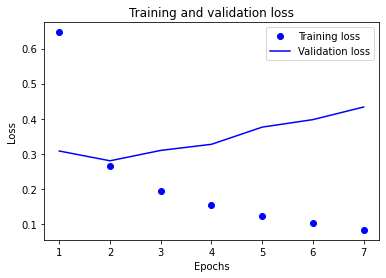

In [10]:
import matplotlib.pyplot as plt
#draw plot for visualization
history_dict = model_history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.show()

In [11]:
# Using the trained model to make prediction on unseen (test) data
# Here we use the 'adapted' text_vectorization layer and include it as part of a prediction_model

prediction_model = tf.keras.Sequential(
    [text_vectorization, model])

prediction_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy'])

# Test it with `val_ds`, which yields raw strings
loss, accuracy = prediction_model.evaluate(val_ds)
print("Accuracy: {:2.2%}".format(accuracy))

47/47 [==============================] - 26s 439ms/step - loss: 0.2780 - accuracy: 0.9074
Accuracy: 90.70%


In [12]:
# Read the test data in the form of a dataframe

df_test_data = pd.read_csv('../input/positionalembedding/data_test_df.csv')
inputs = df_test_data['data']

In [13]:
# Make sure you use the 'prediction_model' and not the trained 'model' alone
# If you use the 'model' object, you will run int error as the data is still in the 'text' format and needs vectorization

predicted_scores = prediction_model.predict(inputs)
predicted_scores[0:5]

array([[5.6576435e-02, 7.3728431e-04, 9.0020889e-01, 4.2477340e-02],
       [2.4851467e-03, 4.2352453e-04, 9.2692962e-03, 9.8782200e-01],
       [2.4341596e-03, 1.2548075e-03, 3.6321532e-02, 9.5998949e-01],
       [7.8615490e-03, 9.3500718e-04, 1.4847216e-01, 8.4273130e-01],
       [5.8548236e-03, 4.3218117e-04, 4.0851049e-02, 9.5286196e-01]],
      dtype=float32)

In [14]:
# populating the dataframe to make a submission on Kaggle

df_predictions = pd.DataFrame(predicted_scores, columns=['solution_' + str(i+1) for i in range(4)])
df_predictions.index.rename('Id', inplace=True)

df_predictions.head(30)

,solution_1,solution_2,solution_3,solution_4
Id,,,,
0,0.056576,0.000737,0.900209,0.042477
1,0.002485,0.000424,0.009269,0.987822
2,0.002434,0.001255,0.036322,0.959989
3,0.007862,0.000935,0.148472,0.842731
4,0.005855,0.000432,0.040851,0.952862
5,0.016511,0.000253,0.046656,0.936580
6,0.015266,0.000183,0.039343,0.945208
7,0.019328,0.020928,0.060148,0.899596
8,0.011721,0.002313,0.192821,0.793146


In [15]:
# If using colab, then download this and submit on Kaggle

df_predictions.to_csv('df_predictions_11.csv')